## Prediction Logic Experiments

+ get image (known faulty, or random)
+ extract board
+ get raw predictions
+ plot raw
+ print board (ASCII)

In [1]:
#from chessvision import classify_raw, load_models
from u_net import load_extractor
from square_classifier import build_square_classifier, load_classifier

board_model = load_extractor()
square_model = load_classifier()
#square_model = build_square_classifier()
#square_model.load_weights("../../weights/best_weights_square.hdf5")

Using Theano backend.


Loading board extraction model..
Loading board extraction model.. DONE
Loading square model..
Loading square model.. DONE


In [128]:
# find a misclassified example!

true_label = "K" # choose a white piece!
img_dir = "../../data/squares/validation/" + true_label + "/"
pieces = os.listdir(img_dir)
label_names  = ['B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r', 'f']

i = 0
while True and i < 1000:
    piece = random.choice(pieces)
    X = cv2.imread(img_dir + piece, 0)
    X = np.expand_dims(X, -1)
    X = np.array([X])
    
    prob = square_model.predict(X)
    
    pred = np.argmax(prob, axis=1)
    pred_label = label_names[pred[0]]
    if pred_label != true_label:
        print(piece)
        misclf_piece = piece
        print(pred_label)
        break
    i += 1
print(i)

g2_b90e50d0-a0d7-41d7-8389-080301ab517c.JPG
f
100


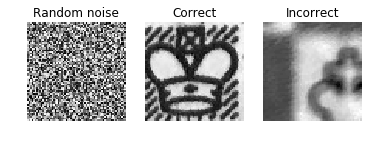

Predictions: ['Q', 'K', 'f']

['B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r', 'f']
[[0.06 0.26 0.01 0.02 0.41 0.14 0.   0.04 0.   0.   0.05 0.01 0.01]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


In [129]:
# demonstrate the bug

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

pieces = os.listdir(img_dir)
piece = random.choice(pieces)

# generate examples
X = np.random.rand(64, 64)
Y = cv2.imread(img_dir + piece, 0)
Z = cv2.imread(img_dir + misclf_piece, 0)

# plot examples
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(X, cmap="gray")
plt.title("Random noise")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(Y, cmap="gray")
plt.title("Correct")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(Z, cmap="gray")
plt.title("Incorrect")
plt.axis("off")
plt.show()

# preprocess
X = np.expand_dims(X, -1)
Y = np.expand_dims(Y, -1)
Z = np.expand_dims(Z, -1)

# predict
batch = np.array([X, Y, Z])
y_batch = square_model.predict(batch)

# display predictions
initial_predictions = np.argmax(y_batch, axis=1)
label_names  = ['B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r', 'f']
pred_labels = [label_names[p] for p in initial_predictions]
print("Predictions: {}\n".format(pred_labels))

np.set_printoptions(suppress=True, precision=2)
print(label_names)
print(y_batch)
#print(np.sum(y_batch, axis=1))


Get predictions + names -- (64 x 13) + (64 x 1)

Apply logic function

In [ ]:
from util import listdir_nohidden
import cv2
import numpy as np

num_boards = 10

raw_dir = "../../data/raw/"
raw_imgs = listdir_nohidden(raw_dir)

raw_batch = np.random.choice(raw_imgs, num_boards)
raw_batch = list(map(lambda f: cv2.imread(raw_dir + f), raw_batch))
resized_batch = np.array(list(map(lambda im: cv2.resize(im, (256, 256), interpolation=cv2.INTER_AREA), raw_batch)))
print(resized_batch.shape)

In [ ]:
from board_extractor import extract_board
import matplotlib.pyplot as plt

i=0
board = extract_board(resized_batch[i], raw_batch[i], board_model)

plt.imshow(board, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
## Taken from board_classifier.py

def classify_board(board_img, model):
    print("Classifying board..")
    squares, names = extract_squares(board_img)
    
    predictions = model.predict(squares)
    print(predictions)
    
    chessboard = classification_logic(predictions, names)
        
    FEN = chessboard.board_fen(promoted=False)
    print("Classifying board.. DONE")
    
    return FEN, predictions, squares, chessboard

def classification_logic(probs, names):
    
    initial_predictions = np.argmax(probs, axis=1)

    label_names  = ['B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r', 'f']

    pred_labels = [label_names[p] for p in initial_predictions]

    pred_labels = check_multiple_kings(pred_labels, probs)
    pred_labels = check_bishops(pred_labels, probs, names)
    pred_labels = check_pawns_not_on_first_rank(pred_labels, probs, names)
    
    board = build_board_from_labels(pred_labels, names)
    
    return board

def check_multiple_kings(pred_labels, probs):
    if pred_labels.count("k") > 1:
        print("Predicted more than two black kings!")
        # all but the most likely black king gets switched to the second most likely piece
    if pred_labels.count("K") > 1:
        print("Predicted more than two white kings!")
        # all but the most likely white king gets switched to the second most likely piece
    return pred_labels

def check_bishops(pred_labels, probs, names):
    # check if more than two dark/light bishops
    # check if dark bishop on light square and vice versa
    return pred_labels

def check_pawns_not_on_first_rank(pred_labels, probs, names):
    first_rank = ["a1", "b1", "c1", "d1", "e1", "f1", "g1", "h1"]
    last_rank = ["a8", "b8", "c8", "d8", "e8", "f8", "g8", "h8"]

    for label, name in zip(pred_labels, names):
        if label == "P":
            if name in first_rank:
                print("White pawn on 1st rank!")
        if label == "p":
            if name in last_rank:
                print("Black pawn on 8th rank!")

    return pred_labels

def build_board_from_labels(labels, names):
    board = chess.BaseBoard(board_fen=None)
    for pred_label, sq in zip(labels, names):
        if pred_label == "f":
            piece = None
        else:
            piece = chess.Piece.from_symbol(pred_label)
        
        square = chess.SQUARE_NAMES.index(sq)
        board.set_piece_at(square, piece, promoted=False)
    return board

def extract_squares(board):
    ranks = ["a", "b", "c", "d", "e", "f", "g", "h"]
    files = ["1", "2", "3", "4", "5", "6", "7", "8"]
    squares = []
    names = []
    ww, hh = board.shape
    w = int(ww / 8)
    h = int(hh / 8)

    for i in range(8):
        for j in range(8):
            squares.append(board[i*w:(i+1)*w, j*h:(j+1)*h])
            names.append(ranks[j]+files[7-i])
    
    squares = np.array(squares)
    squares = np.expand_dims(squares, -1)
    #squares = squares.reshape(squares.shape[0], 64, 64, 1)
    
    return squares, names

In [ ]:
import chess
#from chessvision import classi

FEN, pred, names, chessboard = classify_board(board, square_model)

print(chessboard)